In [45]:
import numpy as np
from qpsolvers import solve_qp  
import pandas as pd
from sklearn.metrics import accuracy_score
class CustomSVM:
    def __init__(self, C=1.0, kernel='linear', degree=1, gamma='auto', sigma=0.05):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.sigma = sigma
        self.gamma = gamma
        self.kernel_function = None
        
    def _linear_kernel(self, X1, X2):
        return np.dot(X1, X2.T)

    def _rbf_kernel(self, X1, X2):
        X1_expanded = np.expand_dims(X1, axis=1)  
        diff = X1_expanded - X2
        norm = np.linalg.norm(diff, axis=2)
        gamma = 1 / (2 * self.sigma**2)  
        return np.exp(-gamma * norm ** 2)
    
    def _poly_kernel(self, X1, X2):
        return (np.dot(X1, X2.T) + 1) ** self.degree

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.X = X
        self.y = y

        if self.kernel == 'linear':
            self.kernel_function = self._linear_kernel
        elif self.kernel == 'rbf':
            self.kernel_function = self._rbf_kernel
        elif self.kernel == 'poly':
            self.kernel_function = self._poly_kernel
        else:
            raise ValueError("Invalid kernel type.")

        self.Gram = self.kernel_function(X, X)

        P = np.outer(y, y) * self.Gram
        q = -np.ones(n_samples)
        G = np.vstack((-np.eye(n_samples), np.eye(n_samples)))
        h = np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C))
        Aeq = y.reshape(1, -1)
        beq = np.array([0.0])
        lb = np.zeros(n_samples)
        ub = self.C * np.ones(n_samples)

        alpha = solve_qp(P, q, G, h, Aeq, beq, lb, ub, solver='clarabel')
        
        eps = 2.2204e-16
        for i in range(alpha.size):
            if alpha[i] >= self.C - np.sqrt(eps):
                alpha[i] = self.C
                alpha[i] = np.round(alpha[i], 6)
            elif alpha[i] <= 0 + np.sqrt(eps):
                alpha[i] = 0
                alpha[i] = np.round(alpha[i], 6)
            else:
                alpha[i] = np.round(alpha[i], 6)
                #print(f"support vector: alpha = {alpha[i]}")

        support_vector_indices = np.where(alpha > 0)[0]
        self.support_vectors = X[support_vector_indices]
        self.support_vector_labels = y[support_vector_indices]

        bias = np.mean(self.support_vector_labels - np.dot(self.Gram[support_vector_indices][:, support_vector_indices], alpha[support_vector_indices] * self.support_vector_labels))
        self.alpha = alpha
        self.bias = bias

    def predict(self, X):
        n_samples = X.shape[0]  
        decision_function = np.zeros(n_samples)  
    
        # 篩選支持向量
        support_vector_indices = np.where(self.alpha > 0)[0]
        support_vectors = self.support_vectors
        support_vector_labels = self.support_vector_labels
    
        # 
        if self.kernel_function is None:
            print("Error: kernel_function is None.")
            return None  #
    
        for i in range(n_samples):
            X1_expanded = np.expand_dims(X[i, :], axis=0)#擴增維度
            decision_function[i] = np.sum(
                self.alpha[support_vector_indices] * support_vector_labels *
                self.kernel_function(X1_expanded, support_vectors)
            ) + self.bias
    
        return np.sign(decision_function)


In [48]:
x_head_12 = pd.read_csv('iris_head_12.txt', delim_whitespace=True)
x_tail_12 = pd.read_csv('iris_tail_12.txt', delim_whitespace=True)
x_head_23 = pd.read_csv('iris_head_23.txt', delim_whitespace=True)
x_tail_23 = pd.read_csv('iris_tail_23.txt', delim_whitespace=True)
x_head_13 = pd.read_csv('iris_head_13.txt', delim_whitespace=True)
x_tail_13 = pd.read_csv('iris_tail_13.txt', delim_whitespace=True)
#for test(三種data)
x_head_test = pd.read_csv('iris_head3.txt', delim_whitespace=True)
x_tail_test = pd.read_csv('iris_tail3.txt', delim_whitespace=True)
# 將標籤值替換為1 -1
x_head_12['species'] = x_head_12['species'].replace({1: -1, 2: 1})
x_tail_12['species'] = x_tail_12['species'].replace({1: -1, 2: 1})
x_head_23['species'] = x_head_23['species'].replace({2: -1, 3: 1})
x_tail_23['species'] = x_tail_23['species'].replace({2: -1, 3: 1})
x_head_13['species'] = x_head_13['species'].replace({1: -1, 3: 1})
x_tail_13['species'] = x_tail_13['species'].replace({1: -1, 3: 1})
#
y_head_12 = x_head_12['species'].values
y_tail_12 = x_tail_12['species'].values
y_head_23 = x_head_23['species'].values
y_tail_23 = x_tail_23['species'].values
y_head_13 = x_head_13['species'].values
y_tail_13 = x_tail_13['species'].values
#for test(三種data)
y_head_test = x_head_test['species'].values
y_tail_test = x_tail_test['species'].values
#drop species
columns_to_drop = ["species"]
x_head_12 = x_head_12.drop(columns_to_drop, axis=1).values
x_tail_12 = x_tail_12.drop(columns_to_drop, axis=1).values
x_head_23 = x_head_23.drop(columns_to_drop, axis=1).values
x_tail_23 = x_tail_23.drop(columns_to_drop, axis=1).values
x_head_13 = x_head_13.drop(columns_to_drop, axis=1).values
x_tail_13 = x_tail_13.drop(columns_to_drop, axis=1).values

x_head_test = x_head_test.drop(columns_to_drop, axis=1).values
x_tail_test = x_tail_test.drop(columns_to_drop, axis=1).values

In [72]:
C_values = [1, 5, 10, 50, 100, 500, 1000]
sigma_values = [1.05 ** i for i in range(-100, 101, 5)]
# 儲存分類率
best_accuracy_head = 0.0
best_accuracy_tail = 0.0
best_accuracy = 0.0
best_params = {}
results = {}
for C_val in C_values:
    for sigma_val in sigma_values:
        #三個SVM training
        svm_rbf_12 = CustomSVM(C=C_val, kernel='rbf', gamma="auto", sigma = sigma_val)
        svm_rbf_23 = CustomSVM(C=C_val, kernel='rbf', gamma="auto", sigma = sigma_val)
        svm_rbf_13 = CustomSVM(C=C_val, kernel='rbf', gamma="auto", sigma = sigma_val)
        svm_rbf_12.fit(x_head_12, y_head_12)
        svm_rbf_23.fit(x_head_23, y_head_23)
        svm_rbf_13.fit(x_head_13, y_head_13)
        #predit
        y_pred_12 = svm_rbf_12.predict(x_tail_test)
        y_pred_23 = svm_rbf_23.predict(x_tail_test)
        y_pred_13 = svm_rbf_13.predict(x_tail_test)
        # 將預測值1替換為2，-1替換為1
        y_pred_12_modified = np.where(y_pred_12 == 1, 2, np.where(y_pred_12 == -1, 1, y_pred_12))
        y_pred_23_modified = np.where(y_pred_23 == 1, 3, np.where(y_pred_23 == -1, 2, y_pred_23))
        y_pred_13_modified = np.where(y_pred_13 == 1, 3, np.where(y_pred_13 == -1, 1, y_pred_13))
        
        #最後結果投票
        final_predictions = []
        # 投票
        for i in range(75):
            votes = [y_pred_12_modified[i], y_pred_23_modified[i], y_pred_13_modified[i]]
            if len(set(votes)) > 2:
                final_predictions.append(4)
            else:
                final_predictions.append(max(set(votes), key=votes.count))
        final_predictions = [int(prediction) for prediction in final_predictions]
        final_predictions
        accuracy = accuracy_score(y_tail_test, final_predictions)
        #print(f"Accuracy_part1: {accuracy}")
        #-----------------CROSS----------------
        #三個SVM training
        svm_rbf_12 = CustomSVM(C=C_val, kernel='rbf', gamma="auto", sigma = sigma_val)
        svm_rbf_23 = CustomSVM(C=C_val, kernel='rbf', gamma="auto", sigma = sigma_val)
        svm_rbf_13 = CustomSVM(C=C_val, kernel='rbf', gamma="auto", sigma = sigma_val)
        svm_rbf_12.fit(x_tail_12, y_tail_12)
        svm_rbf_23.fit(x_tail_23, y_tail_23)
        svm_rbf_13.fit(x_tail_13, y_tail_13)
        #predit
        y_pred_12 = svm_rbf_12.predict(x_head_test)
        y_pred_23 = svm_rbf_23.predict(x_head_test)
        y_pred_13 = svm_rbf_13.predict(x_head_test)
        # 將預測值1替換為2，-1替換為1
        y_pred_12_modified = np.where(y_pred_12 == 1, 2, np.where(y_pred_12 == -1, 1, y_pred_12))
        y_pred_23_modified = np.where(y_pred_23 == 1, 3, np.where(y_pred_23 == -1, 2, y_pred_23))
        y_pred_13_modified = np.where(y_pred_13 == 1, 3, np.where(y_pred_13 == -1, 1, y_pred_13))
        #最後結果投票
        final_predictions = []
        # 投票
        for i in range(75):
            votes = [y_pred_12_modified[i], y_pred_23_modified[i], y_pred_13_modified[i]]
            if len(set(votes)) > 2:
                final_predictions.append(4)
            else:
                final_predictions.append(max(set(votes), key=votes.count))
        final_predictions = [int(prediction) for prediction in final_predictions]
        final_predictions
        accuracy2 = accuracy_score(y_head_test, final_predictions)

        #平均分類率
        acc_final = (accuracy+accuracy2)/2
        #print(f"Accuracy_part2: {accuracy2}")
        #print(f"Avg_accuracy: {(accuracy+accuracy2)/2}")
        # 檢查是否有更好的模型
        if acc_final > best_accuracy:
            best_accuracy = acc_final
            best_params['C'] = C_val
            best_params['sigma'] = sigma_val
        if accuracy > best_accuracy_head:
            best_accuracy_head = accuracy
        if accuracy2 > best_accuracy_tail:
            best_accuracy_tail = accuracy2
        # 保存結果
        results[(C_val, sigma_val)] = acc_final

C:\Users\a567896666\.conda\envs\py39\lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
C:\Users\a567896666\.conda\envs\py39\lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:38: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
C:\Users\a567896666\.conda\envs\py39\lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
C:\Users\a567896666\.conda\envs\py39\lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build

In [73]:
print(f"BEST accuracy: {best_accuracy}")
print(f"BEST accuracy_head: {best_accuracy_head}")
print(f"BEST accuracy_tail: {best_accuracy_head}")
print(f"BEST C: {best_params['C']}")
print(f"BEST sigma: {best_params['sigma']}")


BEST accuracy: 0.9866666666666667
BEST accuracy_head: 0.9866666666666667
BEST accuracy_tail: 0.9866666666666667
BEST C: 100
BEST sigma: 5.5160153675922565


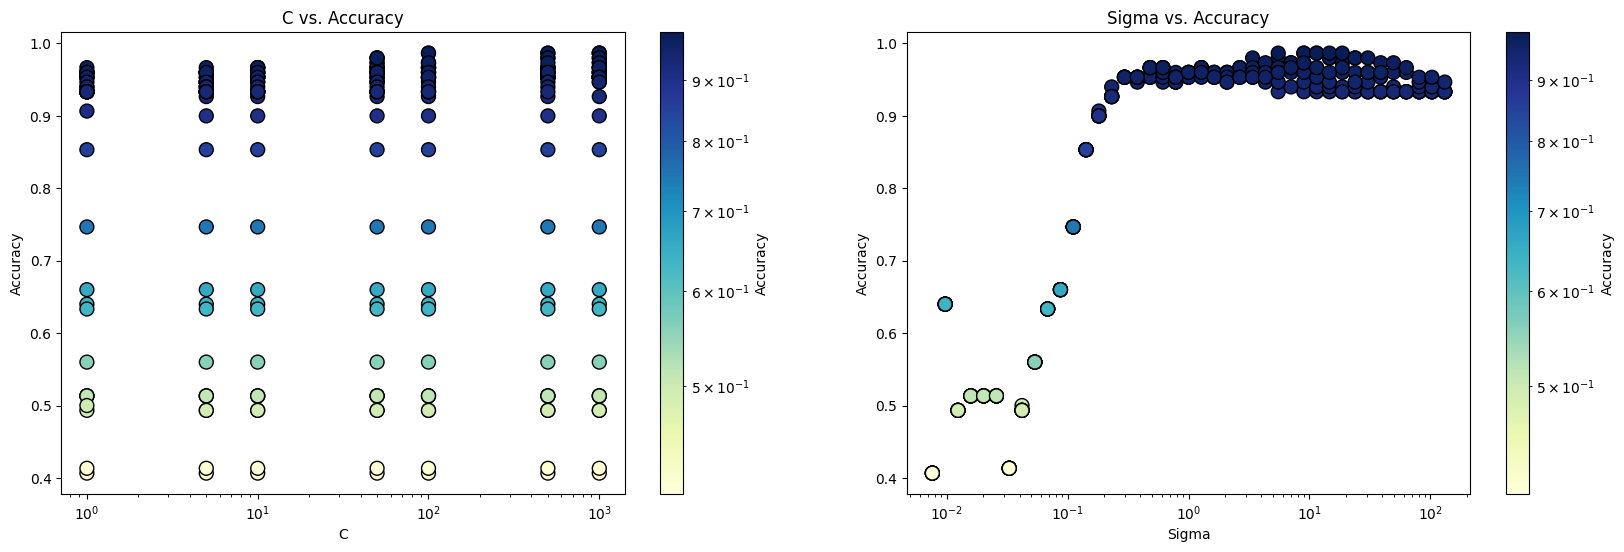

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# 提取 C 和 sigma 的值以及對應的 accuracy
C_values, sigma_values = zip(*results.keys())
accuracies = list(results.values())

# 視覺化結果
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# C 與準確率的關係
sc1 = ax1.scatter(C_values, accuracies, c=accuracies, cmap='YlGnBu', s=100, edgecolors='k', linewidths=1, norm=LogNorm())
ax1.set_xscale('log')  # 因為 C 的範圍很大，使用對數刻度
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy')
ax1.set_title('C vs. Accuracy')
fig.colorbar(sc1, ax=ax1, label='Accuracy')

# Sigma 與準確率的關係
sc2 = ax2.scatter(sigma_values, accuracies, c=accuracies, cmap='YlGnBu', s=100, edgecolors='k', linewidths=1, norm=LogNorm())
ax2.set_xscale('log')  # 因為 Sigma 的範圍很大，使用對數刻度
ax2.set_xlabel('Sigma')
ax2.set_ylabel('Accuracy')
ax2.set_title('Sigma vs. Accuracy')
fig.colorbar(sc2, ax=ax2, label='Accuracy')

plt.show()

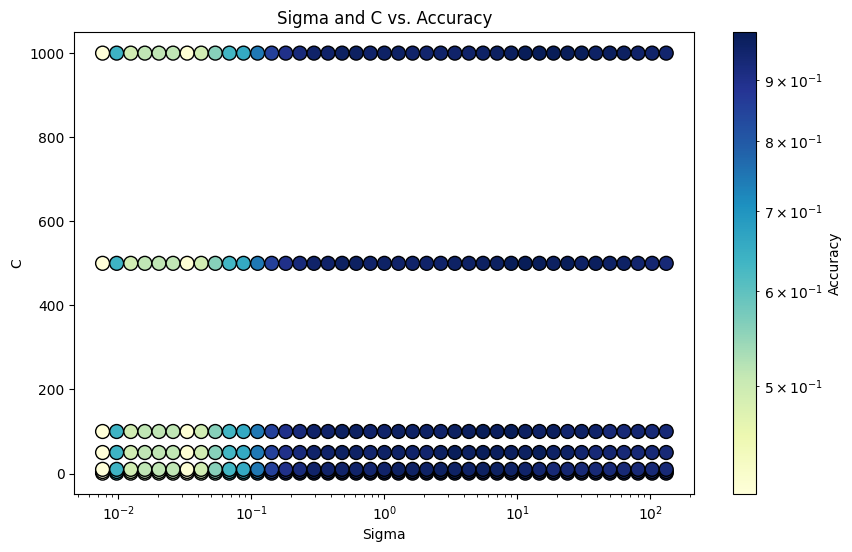

In [77]:
# 視覺化結果
fig, ax = plt.subplots(figsize=(10, 6))

# 繪製散點圖
sc = ax.scatter(sigma_values, C_values, c=accuracies, cmap='YlGnBu', s=100, edgecolors='k', linewidths=1, norm=LogNorm())

# 添加顏色條
cbar = plt.colorbar(sc, ax=ax, label='Accuracy')

# 設置坐標軸標籤和標題
ax.set_xscale('log')  
ax.set_xlabel('Sigma')
ax.set_ylabel('C')
ax.set_title('Sigma and C vs. Accuracy')

plt.show()

In [78]:
# 轉換為 Pandas DataFrame
df = pd.DataFrame(list(results.items()), columns=['Parameters', 'Accuracy'])

# 擴展 Parameters 列為 C 和 Sigma 兩列
df[['C', 'Sigma']] = pd.DataFrame(df['Parameters'].to_list(), index=df.index)

# 刪除原 Parameters 列
df = df.drop('Parameters', axis=1)

# 將 DataFrame 寫入 CSV 文件
df.to_csv('results_table.csv', index=False)